# 📈 Monthly Sales Forecasting: Multi-Model Multivariate Analysis

## 🎯 **Objective**
Revenue forecasting system leveraging multivariate time-series analysis with engineered features from transaction-level data.

## 🔧 **What This Notebook Does**

### **📊 Data Pipeline**
- **Database Integration**: Connects to PostgreSQL database with comprehensive error handling
- **Feature Engineering**: Creates 19 multivariate features including customer behavior, product metrics, and operational indicators
- **Data Processing**: Processes transaction-level sales data into monthly feature matrices
- **Data Handling**: Extrapolates partial Sept 2025 data (19 days → full month) with synthetic transaction generation

### **🤖 Multi-Model Framework**
- **XGBoost Regressor**: Gradient boosting with Optuna hyperparameter optimization (250 trials)
- **Random Forest**: Ensemble method for comparison and feature importance analysis
- **Ridge Regression**: Linear model with L2 regularization for baseline performance  
- **Lasso Regression**: Linear model with L1 regularization and feature selection
- **Comprehensive Evaluation**: MAE, RMSE, R², MAPE, sMAPE metrics with diagnostic plots

### **📅 Time Series Design**
- **Training Period**: 2023-10 → 2025-03 (17 months of multivariate features)
- **Testing Period**: 2025-04 → 2025-08 (5 months hold-out validation)  
- **Forecasting Target**: October 2025 revenue prediction using engineered feature averaging
- **Business Logic**: Filters and handles partial month extrapolation with transaction sampling

### **🎯 Key Deliverables**
- **Model Comparison Matrix**: Performance metrics across XGBoost, Random Forest, Ridge, and Lasso
- **Feature Importance Analysis**: Built-in XGBoost metrics (Gain, Cover) and permutation importance
- **Future Forecasting**: October 2025 revenue predictions from best-performing multivariate model
- **Production Code**: Clean, documented, memory-optimized code ready for deployment
- **Diagnostic Analysis**: Correlation matrices and model validation with business insights

## Prerequisites & Setup Instructions

Before running this notebook, ensure you have:

1. **PostgreSQL Database Running**: Make sure your database is accessible
2. **Environment File**: Create / use a `.env` file in the same directory with:
   ```
   PG_USER=your_username
   PG_PASSWORD=your_password
   PG_DB=your_database_name
   PG_PORT=5432
   ```
3. **Required Packages**: All packages will be installed automatically when you run the import cell

**Execution Order**: Run cells sequentially from top to bottom for best results.

## 1. Importing Libraries and Utility Functions

In [1]:
# =============================================================================
# AUTO-INSTALL REQUIREMENTS (Run this first if packages are missing)
# =============================================================================
import subprocess
import sys
import os

def install_requirements():
    """Install packages from requirements.txt if they don't exist."""
    try:
        requirements_file = "Requirements.txt"
        if os.path.exists(requirements_file):
            print("📦 Installing missing packages from Requirements.txt...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", requirements_file])
            print("✅ All packages installed successfully!")
        else:
            print("⚠️  Requirements.txt not found in current directory")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error installing packages: {e}")

# Uncomment the line below to auto-install packages on first run
# install_requirements()

# =============================================================================
# IMPORTS - All Required Libraries
# =============================================================================

# Core data manipulation and numerical computing
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display

# Database connection and environment management
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

# Machine Learning - XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Machine Learning - Additional algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

# Machine Learning - Scikit-learn metrics and model selection
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance

# Hyperparameter optimization
import optuna

**⚠️ IMPORTANT: Execute this cell first before running any other cells in the notebook!**

**🔧 For First-Time Setup:**
If this is your first time running the notebook, uncomment the `install_requirements()` line in the next cell to automatically install all required packages from `Requirements.txt`.

In [2]:
## utility functions

def extrapolate_sep2025(df):
    """
    Extrapolate partial September 2025 sales data to full month using synthetic transaction generation.
    
    Creates realistic synthetic transactions for missing days by sampling from existing
    transactions and scaling to achieve proportional monthly totals based on observed
    daily averages. Maintains transaction-level granularity for feature engineering.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Transaction-level sales data containing 'order_date', 'revenue', 'quantity',
        'price', 'price_per_item', and 'order_id' columns
        
    Returns:
    --------
    pd.DataFrame
        Complete September 2025 dataset with both actual and synthetic transactions,
        extrapolated to full 30-day month based on observed daily patterns
        
    Business Logic:
    ---------------
    - Calculates scaling factor from observed days (e.g., 19 days → 30 days)
    - Samples existing transactions to create synthetic data for missing days
    - Proportionally scales revenue and quantity to hit monthly targets
    - Preserves transaction diversity and customer behavior patterns
    """
    # Filter September 2025 transactions
    sept_df = df[(df["order_date"].dt.year == 2025) & (df["order_date"].dt.month == 9)]

    # Identify missing days in September 2025
    all_days = pd.date_range("2025-09-01", "2025-09-30", freq="D")
    present_days = sept_df["order_date"].dt.normalize().unique()
    missing_days = sorted(set(all_days) - set(present_days))

    # Calculate extrapolation targets based on daily averages
    days_present = len(present_days)
    days_in_month = 30
    scaling_factor = days_in_month / days_present

    target_revenue = sept_df["revenue"].sum() * scaling_factor
    target_quantity = sept_df["quantity"].sum() * scaling_factor

    # Calculate incremental revenue/quantity needed from synthetic transactions
    current_revenue = sept_df["revenue"].sum()
    current_quantity = sept_df["quantity"].sum()

    needed_revenue = target_revenue - current_revenue
    needed_quantity = target_quantity - current_quantity

    # Generate synthetic transactions by sampling existing patterns
    avg_rows_per_day = int(round(len(sept_df) / len(present_days)))
    synthetic_rows = []
    for day in missing_days:
        sampled = sept_df.sample(avg_rows_per_day, replace=True).copy()
        sampled["order_date"] = day
        sampled["order_id"] = sampled["order_id"].astype(str) + "_synthetic_" + day.strftime("%d")
        synthetic_rows.append(sampled)

    synthetic_df = pd.concat(synthetic_rows, ignore_index=True)

    # Scale synthetic transactions to achieve monthly targets
    scaling_revenue = needed_revenue / synthetic_df["revenue"].sum()
    scaling_quantity = needed_quantity / synthetic_df["quantity"].sum()

    synthetic_df["revenue"] = synthetic_df["revenue"] * scaling_revenue
    synthetic_df["price"] = synthetic_df["price"] * scaling_revenue
    synthetic_df["price_per_item"] = synthetic_df["price_per_item"] * scaling_revenue
    synthetic_df["quantity"] = synthetic_df["quantity"] * scaling_quantity

    # Ensure quantity remains integer for realistic transactions
    synthetic_df["quantity"] = synthetic_df["quantity"].round().astype(int)

    # Combine actual and synthetic transactions
    sept_complete = pd.concat([sept_df, synthetic_df], ignore_index=True).sort_values("order_date")

    print(f"Actual Revenue for {len(present_days)} days: {current_revenue:,.2f}")
    print(f"Estimated Sept Revenue: {sept_complete['revenue'].sum():,.2f}")
    print(f"Actual Quantity for {len(present_days)} days: {current_quantity:,.0f}")
    print(f"Estimated Sept Quantity: {sept_complete['quantity'].sum():,.0f}")
    
    return sept_complete


def evaluate_forecast(y_true, y_pred):
    """
    Comprehensive evaluation of forecasting model performance.
    
    Calculates multiple regression and forecasting-specific metrics to assess
    model accuracy, including error metrics (MAE, RMSE), percentage errors
    (MAPE, sMAPE), and goodness-of-fit measures (R²).
    
    Parameters:
    -----------
    y_true : array-like
        Actual observed values (ground truth revenue)
    y_pred : array-like  
        Model predictions for the same time periods
        
    Returns:
    --------
    pd.Series
        Dictionary-like series containing all evaluation metrics:
        - MAE: Mean Absolute Error (revenue units)
        - RMSE: Root Mean Square Error (revenue units)  
        - R2: R-squared coefficient of determination
        - MAPE: Mean Absolute Percentage Error (%)
        - sMAPE: Symmetric Mean Absolute Percentage Error (%)
        - MedAE: Median Absolute Error (robust to outliers)
        - MBE: Mean Bias Error (systematic over/under-prediction)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Standard metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    
    # Percentage-based metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    smape = 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
    
    # Bias
    mbe = np.mean(y_true - y_pred)
    
    results = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE (%)": mape,
        "sMAPE (%)": smape,
        "MedAE": medae,
        "MBE (bias)": mbe
    }
    
    return pd.Series(results)

def evaluate_forecast_with_plots(y_true, y_pred):
    """
    Comprehensive model evaluation combining metrics and diagnostic visualizations.
    
    Evaluates forecasting model performance through quantitative metrics and
    generates diagnostic plots to assess prediction quality, residual patterns,
    and potential model biases.
    
    Parameters:
    -----------
    y_true : array-like
        Actual observed revenue values 
    y_pred : array-like
        Model predictions for corresponding periods
        
    Returns:
    --------
    pd.Series
        Complete evaluation metrics (same as evaluate_forecast)
        
    Side Effects:
    ------------
    Displays three diagnostic plots:
    1. Actual vs Predicted scatter plot with perfect prediction line
    2. Residuals over time to detect temporal patterns
    3. Residuals histogram with normality assessment
    """
    # --- Metrics ---
    metrics = evaluate_forecast(y_true, y_pred)
    print("📊 Forecast Evaluation Metrics:\n")
    print(metrics.round(3))

    # --- Residuals ---
    residuals = y_true - y_pred

    # --- 1. Scatter plot: Actual vs Predicted ---
    plt.figure(figsize=(12, 5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="--", label="Perfect Prediction")
    plt.title("Actual vs Predicted Revenue")
    plt.xlabel("Actual Revenue")
    plt.ylabel("Predicted Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 2. Residual plot (errors over time/index) ---
    plt.figure(figsize=(12, 4))
    plt.plot(residuals, marker="o", linestyle="-", color="orange")
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Residuals (Actual - Predicted) Over Test Period")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Residual (Error)")
    plt.grid(True)
    plt.show()

    # --- 3. Distribution of residuals ---
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=10, color="purple")
    plt.axvline(0, color="red", linestyle="--")
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.show()

    return metrics

def plot_prediction(train_feat, test_feat, y_pred_train, y_pred_test, plot_title="Revenue Prediction Visualization"):
    """
    Create time series visualization comparing actual vs predicted revenue.
    
    Generates a comprehensive plot showing model performance across training
    and testing periods, with clear visual distinction between periods and
    shaded test region for easy interpretation.
    
    Parameters:
    -----------
    train_feat : pd.DataFrame
        Training dataset with 'year_month' and 'revenue' columns
    test_feat : pd.DataFrame  
        Testing dataset with 'year_month' and 'revenue' columns
    y_pred_train : array-like
        Model predictions for training period
    y_pred_test : array-like
        Model predictions for testing period  
    plot_title : str, default="Revenue Prediction Visualization"
        Title for the generated plot
        
    Side Effects:
    ------------
    Displays matplotlib figure with:
    - Actual revenue as solid line with markers
    - Predicted revenue as dashed line with markers  
    - Shaded testing period for clear train/test distinction
    - Formatted dates on x-axis for readability
    """
    def to_timestamp(series):
        if isinstance(series.dtype, pd.PeriodDtype):
            return series.dt.to_timestamp()
        return pd.to_datetime(series)

    actual = (
        pd.concat([train_feat, test_feat], ignore_index=True)
        .assign(ts=lambda df: to_timestamp(df["year_month"]))
        .sort_values("ts")
    )

    predicted = (
        pd.concat(
            [
                train_feat.assign(pred=y_pred_train),
                test_feat.assign(pred=y_pred_test),
            ],
            ignore_index=True,
        )
        .assign(ts=lambda df: to_timestamp(df["year_month"]))
        .sort_values("ts")
    )

    test_start = to_timestamp(test_feat["year_month"]).iloc[0]

    plt.figure(figsize=(14, 6))
    plt.plot(actual["ts"], actual["revenue"], label="Actual", marker="o", color="tab:blue")
    plt.plot(predicted["ts"], predicted["pred"], label="Predicted", marker="o", linestyle="--", color="tab:orange")

    plt.axvspan(test_start, predicted["ts"].iloc[-1], color="gray", alpha=0.1, label="Test window")
    plt.title(plot_title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Revenue", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    
def plot_model_comparison(train_features, test_features, models, names, oct_predictions=None, include_forecast=True):
    """
    Unified plotting function for model comparison with optional October 2025 forecasts.
    
    Parameters:
    -----------
    train_feat : pd.DataFrame
        Training feature data (not used directly, but for consistency)
    test_feat : pd.DataFrame  
        Testing feature data (not used directly, but for consistency)
    models : list
        List of trained model objects
    names : list
        List of model names corresponding to models
    oct_predictions : dict, optional
        Dictionary mapping model names to October 2025 predictions
        If None, only train+test predictions are shown
    include_forecast : bool, default=True
        Whether to include October 2025 forecast in the plot
        
    Features:
    ---------
    - Actual: solid thick black line with circles
    - Each model: dashed line with dots in different colors
    - Consistent styling throughout the notebook
    - Flexible: works with or without October 2025 forecasts
    """
    # Merge train + test for actual revenue
    actual_df = pd.concat([train_features[["year_month","revenue"]],
                           test_features[["year_month","revenue"]]])
    
    # Determine if we should include October 2025 forecast
    include_oct_2025 = include_forecast and oct_predictions is not None
    
    if include_oct_2025:
        # Add October 2025 placeholder for extended timeline
        oct_2025_row = pd.DataFrame({
            "year_month": [pd.Period("2025-10", freq="M")],
            "revenue": [np.nan]  # Unknown actual value
        })
        actual_df_extended = pd.concat([actual_df, oct_2025_row], ignore_index=True)
        title_suffix = " with October 2025 Forecast"
    else:
        title_suffix = ""

    plt.figure(figsize=(14,6))

    # Plot actual revenue (solid black) - always exclude October 2025 since it's unknown
    actual_x = actual_df["year_month"].astype(str).tolist()
    plt.plot(actual_x, actual_df["revenue"], 
             color="black", linewidth=2.5, linestyle="-", marker="o", 
             label="Actual Revenue")

    # Plot predictions for each model
    for model, name in zip(models, names):
        # Extract feature matrices from the passed dataframes
        train_X = train_features.drop(columns=["year_month", "revenue"])
        test_X = test_features.drop(columns=["year_month", "revenue"])
        
        # Predict for train and test periods
        y_pred_train = model.predict(train_X)
        y_pred_test  = model.predict(test_X)

        # Start with train + test predictions
        pred_df = pd.concat([
            pd.DataFrame({"year_month": train_features["year_month"].astype(str), "y_pred": y_pred_train}),
            pd.DataFrame({"year_month": test_features["year_month"].astype(str), "y_pred": y_pred_test})
        ])
        
        # Add October 2025 prediction if available
        if include_oct_2025:
            y_pred_oct = oct_predictions[name]
            oct_pred_df = pd.DataFrame({"year_month": ["2025-10"], "y_pred": [y_pred_oct]})
            pred_df = pd.concat([pred_df, oct_pred_df])

        plt.plot(pred_df["year_month"], pred_df["y_pred"], 
                 linestyle="--", linewidth=2, marker=".", label=name)

    # Consistent styling
    plt.title(f"Revenue Forecasting: All Models Comparison{title_suffix}", fontsize=14)
    plt.xlabel("Year-Month")
    plt.ylabel("Revenue")
    plt.xticks(rotation=45)
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()



## 2. Connect and load Data from Postgres SQL database

In [3]:
# Load variables from .env file (must be in same folder, or pass path)
load_dotenv(".env")

# Read environment variables
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_DB = os.getenv("PG_DB")
PG_PORT = os.getenv("PG_PORT", "5432")  # default to 5432
PG_HOST = "localhost"  # since DB runs in Docker and Python runs locally

# URL-encode password to handle special characters like '@'
PG_PASSWORD_ENC = quote_plus(PG_PASSWORD)

# Validate environment variables
if not all([PG_USER, PG_PASSWORD, PG_DB]):
    raise ValueError("Missing required environment variables. Please check your .env file.")

# Build SQLAlchemy engine with psycopg driver
conn_str = f"postgresql+psycopg://{PG_USER}:{PG_PASSWORD_ENC}@{PG_HOST}:{PG_PORT}/{PG_DB}"

try:
    engine = create_engine(conn_str, pool_pre_ping=True)
    
    # Test connection and load data
    with engine.connect() as conn:
        print("✓ Connected to database successfully")
        result = conn.execute(text("SELECT current_database(), current_user"))
        print("Database, user:", result.all())
        
        # Check available tables
        tables = conn.execute(text(
            "SELECT table_schema, table_name FROM information_schema.tables WHERE table_type='BASE TABLE' AND table_schema NOT IN ('pg_catalog', 'information_schema');"
        ))
        print("\nTables in database:")
        for row in tables:
            print(f"{row.table_schema}.{row.table_name}")
        
        # Load data from tables
        df_customers = pd.read_sql_query("SELECT * FROM sales.customers;", engine)
        df_order_items = pd.read_sql("SELECT * FROM sales.order_items;", engine)
        df_orders = pd.read_sql("SELECT * FROM sales.orders;", engine)
        df_products = pd.read_sql("SELECT * FROM sales.products;", engine)

        print(f"\n✓ Data loaded successfully. Number of customers: {len(df_customers)}")
        
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please check your database connection and .env file configuration.")
    raise



✓ Connected to database successfully
Database, user: [('SalesData', 'guru')]

Tables in database:
sales.products
sales.customers
sales.orders
sales.order_items

✓ Data loaded successfully. Number of customers: 1000


## 3. Data Cleaning and preparation

In [4]:
# Merge dataframes to create master dataframe

# Merge order_items with products to get product details for each order item
order_items_with_products = pd.merge(
    df_order_items,
    df_products,
    on='product_id',
    suffixes=('_orderitem', '_product')
)

# Merge customers with orders to get customer details for each order
orders_with_customers = pd.merge(
    df_customers,
    df_orders,
    on='customer_id',
    suffixes=('_customer', '_order')
)

# Merge the above two to get the full master sales dataset
raw_sales_data = pd.merge(
    orders_with_customers,
    order_items_with_products,
    on='order_id',
    suffixes=('_order', '_orderitem')
)
# Optional: save to CSV for quick access during development
# raw_sales_data.to_csv("raw_sales_data.csv", index=False)
print(raw_sales_data.head())


                            customer_id          name                  email  \
0  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
1  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
2  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
3  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
4  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   

    join_date                              order_id  \
0  2024-05-31  c9e0b356-e045-4327-93e6-affc93a801d2   
1  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   
2  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   
3  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   
4  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   

                  order_date     status                         order_item_id  \
0 2024-04-24 17:20:23.388467    shipped  56aa42e2-19a2-4723-8d46-f43184cd21bd   
1 2024-03-28 04:22:41.2527

In [5]:
#-----------------------------
# Data check and cleaning
#-----------------------------

# Calculate total revenue for each transaction (quantity × unit price)
raw_sales_data["revenue"] = raw_sales_data["quantity"] * raw_sales_data["price_per_item"]

# Data quality checks: missing values and duplicates
print("Missing values per column:\n", raw_sales_data.isna().sum())
print("Number of duplicate rows:", raw_sales_data.duplicated().sum())

# Data type conversions for proper temporal analysis
print("Data types:\n", raw_sales_data.dtypes)
raw_sales_data["join_date"] = pd.to_datetime(raw_sales_data["join_date"])
raw_sales_data["order_date"] = pd.to_datetime(raw_sales_data["order_date"])
raw_sales_data = raw_sales_data.sort_values('order_date').reset_index(drop=True)

# Data cleaning: Remove irrelevant columns and apply business logic filters
filtered_sales_data = raw_sales_data.copy()
filtered_sales_data = filtered_sales_data.drop(["email", "order_item_id", "join_date", "name"], axis=1)

# Filter out discounted/promotional items by comparing unit price with product price
filtered_sales_data = filtered_sales_data[filtered_sales_data["price_per_item"] <= filtered_sales_data["price"]]

filtered_sales_data.head()

#-----------------------------
# Data Preparation for Visualizations
#-----------------------------

# Daily revenue aggregation for time series analysis
daily_revenue_data = (
    filtered_sales_data.set_index("order_date")
    .resample("D")["revenue"].sum()
    .asfreq("D", fill_value=0)
    .reset_index()
    .rename(columns={"order_date": "order_day", "revenue": "daily_revenue"})
)
daily_revenue_data["year_month"] = daily_revenue_data["order_day"].dt.to_period("M").astype(str)

# Monthly revenue aggregation - primary time series for modeling
monthly_revenue_data = (
    filtered_sales_data.assign(order_year=filtered_sales_data["order_date"].dt.year,
                              order_month=filtered_sales_data["order_date"].dt.month)
    .groupby(["order_year", "order_month"], as_index=False)
    .agg(
        total_revenue=("revenue", "sum"),
    )
)
monthly_revenue_data["year_month"] = (
    monthly_revenue_data["order_year"].astype(str) + "-" + monthly_revenue_data["order_month"].astype(str).str.zfill(2)
)

# Category-wise revenue analysis over time
category_revenue_trends = (
    filtered_sales_data.assign(year_month=filtered_sales_data["order_date"].dt.to_period("M").astype(str))
    .groupby(["year_month", "category"])["revenue"]
    .sum()
    .reset_index()
)

# Order status analysis over time (business health metric)
order_status_trends = (
    filtered_sales_data.drop_duplicates(subset=["order_id", "status"])
    .assign(year_month=filtered_sales_data["order_date"].dt.to_period("M").astype(str))
    .groupby(["year_month", "status"])["order_id"]
    .count()
    .reset_index(name="order_count")
)

# Seasonal patterns analysis (month-over-month trends)
seasonal_revenue_patterns = (
    filtered_sales_data.assign(
        order_month=filtered_sales_data["order_date"].dt.month,
        order_month_name=filtered_sales_data["order_date"].dt.strftime("%b"),
    )
    .groupby(["order_month", "order_month_name"], as_index=False)["revenue"]
    .sum()
    .sort_values("order_month")
)




Missing values per column:
 customer_id       0
name              0
email             0
join_date         0
order_id          0
order_date        0
status            0
order_item_id     0
product_id        0
quantity          0
price_per_item    0
product_name      0
category          0
price             0
revenue           0
dtype: int64
Number of duplicate rows: 0
Data types:
 customer_id               object
name                      object
email                     object
join_date                 object
order_id                  object
order_date        datetime64[ns]
status                    object
order_item_id             object
product_id                object
quantity                   int64
price_per_item           float64
product_name              object
category                  object
price                    float64
revenue                  float64
dtype: object


## 4. Data visualization

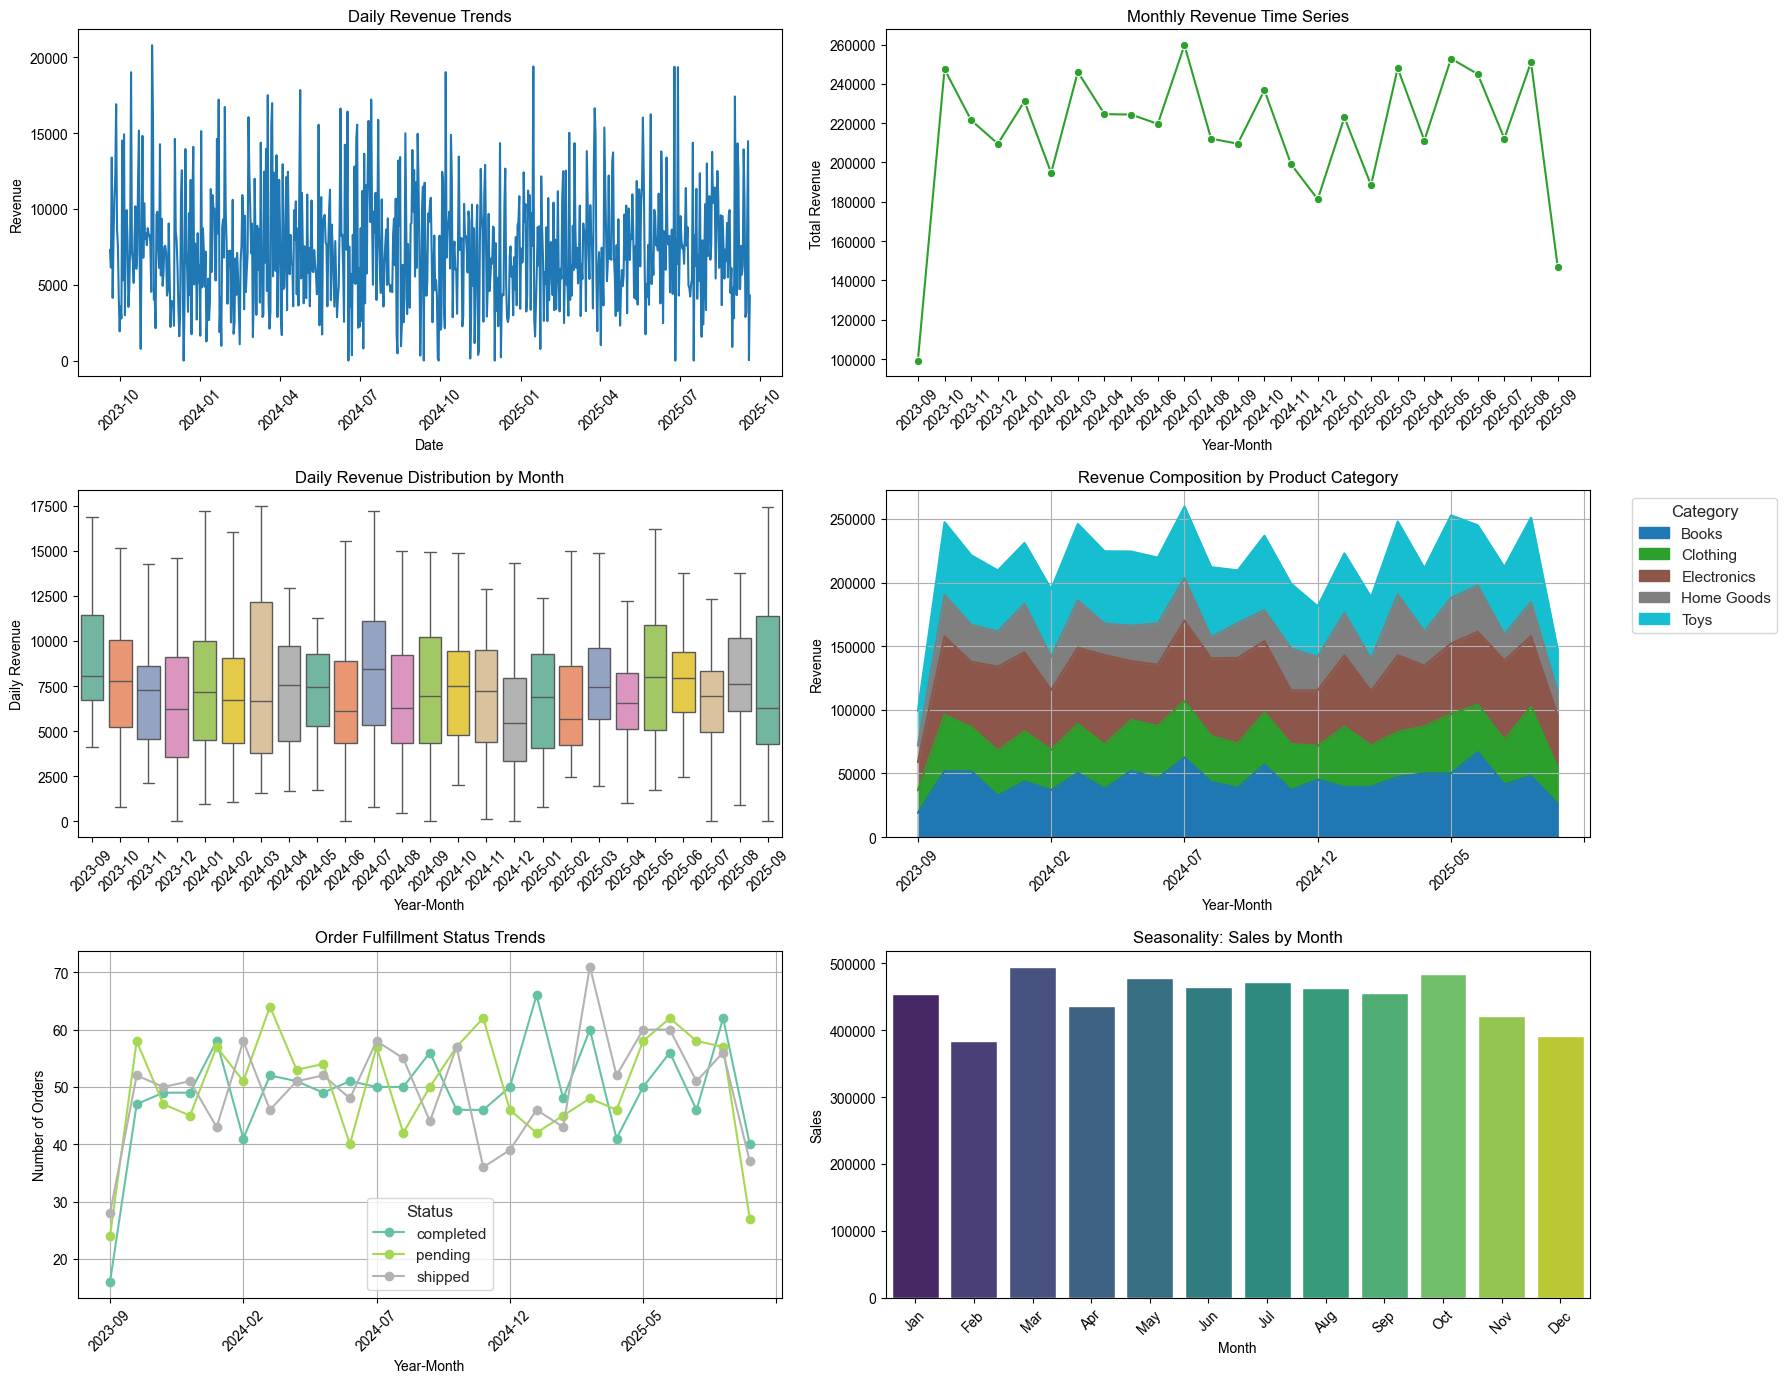

In [6]:
# -----------------------------
# Visualization in Subplots
# -----------------------------

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()
sns.set_theme(style="whitegrid")
# 1. Daily revenue trend analysis
sns.lineplot(data=daily_revenue_data, x="order_day", y="daily_revenue", ax=axes[0], color="tab:blue")
axes[0].set_title("Daily Revenue Trends")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Revenue")
axes[0].tick_params(axis="x", rotation=45)

# 2. Monthly revenue aggregation (main time series)
sns.lineplot(data=monthly_revenue_data, x="year_month", y="total_revenue",
             marker="o", ax=axes[1], color="tab:green")
axes[1].set_title("Monthly Revenue Time Series")
axes[1].set_xlabel("Year-Month")
axes[1].set_ylabel("Total Revenue")
axes[1].tick_params(axis="x", rotation=45)

# 3. Daily revenue variability analysis
sns.boxplot(data=daily_revenue_data, x="year_month", y="daily_revenue",
            showfliers=False, ax=axes[2], hue="year_month", legend=False, palette="Set2")
axes[2].set_title("Daily Revenue Distribution by Month")
axes[2].set_xlabel("Year-Month")
axes[2].set_ylabel("Daily Revenue")
axes[2].tick_params(axis="x", rotation=45)

# 4. Product category revenue composition
revenue_by_category = category_revenue_trends.pivot(index="year_month", columns="category", values="revenue")
revenue_by_category.plot(kind="area", stacked=True, ax=axes[3], colormap="tab10")
axes[3].set_title("Revenue Composition by Product Category")
axes[3].set_xlabel("Year-Month")
axes[3].set_ylabel("Revenue")
axes[3].legend(title="Category", bbox_to_anchor=(1.05, 1))
axes[3].tick_params(axis="x", rotation=45)

# 5. Business health: Order fulfillment trends
order_status_pivot = order_status_trends.pivot(index="year_month", columns="status", values="order_count")
order_status_pivot.plot(kind="line", ax=axes[4], marker="o", colormap="Set2")
axes[4].set_title("Order Fulfillment Status Trends")
axes[4].set_xlabel("Year-Month")
axes[4].set_ylabel("Number of Orders")
axes[4].legend(title="Status")
axes[4].tick_params(axis="x", rotation=45)

# 6. Seasonal revenue patterns analysis
sns.barplot(data=seasonal_revenue_patterns, x="order_month_name", y="revenue",
            order=seasonal_revenue_patterns["order_month_name"].tolist(),
            ax=axes[5], hue="order_month_name", legend=False, palette="viridis")
axes[5].set_title("Seasonality: Sales by Month")
axes[5].set_xlabel("Month")
axes[5].set_ylabel("Sales")
axes[5].tick_params(axis="x", rotation=45)



fig.tight_layout()
plt.show()


My interpretation :

Based on the visualizations, the sales data shows relatively stable patterns over time.

- The daily revenue fluctuates with occasional spikes, but overall variation appears stationary rather than strongly trending. 
- At the monthly level, revenue remains fairly consistent with moderate ups and downs, suggesting no dominant long-term trend. 
- The distribution of daily revenues by month confirms this stability, though variability differs slightly across months. 
- Category-wise, Electronics and Home Goods drive the majority of sales, while Books, Clothing, and Toys contribute less but remain steady. 
- Order statuses (completed, pending, shipped) follow consistent patterns without major shifts, indicating stable operational processes. 
- Seasonality by month shows only mild seasonal variation, with some months slightly higher (spring and summer) and December somewhat lower, but not enough to suggest strong seasonality. 

Overall, the dataset looks largely stationary with weak seasonal effects, which is important to consider when selecting forecasting models.

## 5. Feature Engineering

In [7]:

def create_features_safe(df, add_lags=False):
    """
    Generate comprehensive monthly feature matrix from transaction-level sales data.
    
    Creates 15+ engineered features including customer behavior metrics, operational
    indicators, and temporal patterns while avoiding data leakage by separating
    target variable (revenue) from predictive features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Transaction-level sales data with columns: order_date, revenue, customer_id,
        product_name, quantity, order_id, status
    add_lags : bool, default=False
        Whether to include lagged revenue features for time series forecasting
        
    Returns:
    --------
    pd.DataFrame
        Monthly feature matrix with engineered variables suitable for ML models:
        - Customer metrics: unique customers, repeat behavior, loyalty indicators
        - Product metrics: variety, quantity patterns
        - Operational metrics: order status distribution, completion rates
        - Temporal features: month, quarter, year for seasonality modeling
        - Optional lag features: previous month revenue patterns
        
    Business Logic:
    ---------------
    - Aggregates transaction data to monthly granularity
    - Creates ratio features for normalized comparisons
    - Handles missing values with forward fill for robustness
    - Maintains temporal ordering for proper train/test splitting
    """
    df = df.copy()
    df["order_date"] = pd.to_datetime(df["order_date"])
    df["year_month"] = df["order_date"].dt.to_period("M")

    # Base monthly aggregation (target variable separated to prevent leakage)
    monthly_feature_base = (
        df.groupby("year_month")
        .agg(
            # Target variable (revenue) kept separate for supervised learning
            revenue=("revenue", "sum"),
            num_customers=("customer_id", "nunique"),
            num_products=("product_name", "nunique"),
            total_quantity=("quantity", "sum"),
        )
        .reset_index()
    )

    # Customer behavior analysis: repeat customers and loyalty indicators
    customer_behavior = (
        df.groupby(["year_month", "customer_id"])["order_id"]
        .nunique()
        .reset_index(name="orders_per_customer")
    )
    customer_behavior["is_repeat_customer"] = customer_behavior["orders_per_customer"] >= 2
    
    repeat_customer_metrics = (
        customer_behavior.groupby("year_month")["is_repeat_customer"]
        .sum()
        .reset_index(name="num_repeat_customers")
    )
    
    repeat_order_volume = (
        customer_behavior.loc[customer_behavior["is_repeat_customer"]]
        .groupby("year_month")["orders_per_customer"]
        .sum()
        .reset_index(name="num_repeat_orders")
    )

    # Operational health metrics: order status distribution
    order_status_distribution = (
        df.groupby(["year_month", "status"])["order_id"]
        .nunique()
        .unstack(fill_value=0)
        .reset_index()
    )
    
    # Ensure all status columns exist for consistent feature matrix
    for status_type in ["completed", "pending", "shipped"]:
        if status_type not in order_status_distribution:
            order_status_distribution[status_type] = 0

    # Combine all feature components into comprehensive monthly dataset
    monthly_features = (
        monthly_feature_base
        .merge(repeat_customer_metrics, on="year_month", how="left")
        .merge(repeat_order_volume, on="year_month", how="left")
        .merge(order_status_distribution, on="year_month", how="left")
        .fillna(0)
    )

    # Business performance ratios (normalized metrics for model robustness)
    monthly_features["total_orders"] = monthly_features["completed"] + monthly_features["pending"] + monthly_features["shipped"]
    monthly_features["completed_rate"] = monthly_features["completed"] / monthly_features["total_orders"].replace(0, np.nan)
    monthly_features["pending_rate"] = monthly_features["pending"] / monthly_features["total_orders"].replace(0, np.nan)
    monthly_features["shipped_rate"] = monthly_features["shipped"] / monthly_features["total_orders"].replace(0, np.nan)
    monthly_features["repeat_customer_share"] = monthly_features["num_repeat_customers"] / monthly_features["num_customers"].replace(0, np.nan)
    monthly_features["repeat_order_share"] = monthly_features["num_repeat_orders"] / monthly_features["total_quantity"].replace(0, np.nan)

    # Temporal features for seasonality modeling
    monthly_features["month"] = monthly_features["year_month"].dt.month
    monthly_features["quarter"] = monthly_features["year_month"].dt.quarter
    monthly_features["year"] = monthly_features["year_month"].dt.year

    # Optional lag features for time series forecasting (prevent data leakage)
    if add_lags:
        monthly_features = monthly_features.sort_values("year_month").reset_index(drop=True)
        monthly_features["revenue_lag1"] = monthly_features["revenue"].shift(1)
        monthly_features["revenue_lag3"] = monthly_features["revenue"].shift(3).rolling(3).mean()

    return monthly_features.sort_values("year_month").reset_index(drop=True)


## 6. Train-Test Split

Extrapolating Sep 2025 to full month...
Actual Revenue for 19 days: 147,001.36
Estimated Sept Revenue: 232,107.41
Actual Quantity for 19 days: 612
Estimated Sept Quantity: 973
Complete months (24): 2023-10, 2023-11, 2023-12, 2024-01, 2024-02, 2024-03, 2024-04, 2024-05, 2024-06, 2024-07, 2024-08, 2024-09, 2024-10, 2024-11, 2024-12, 2025-01, 2025-02, 2025-03, 2025-04, 2025-05, 2025-06, 2025-07, 2025-08, 2025-09
Partial months kept aside (1): 2023-09
Total available months: 24 → 2023-10 to 2025-09
Data Split: Training: 19 months, Testing: 5 months
Training months: ['2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04']
Testing months: ['2025-05', '2025-06', '2025-07', '2025-08', '2025-09']


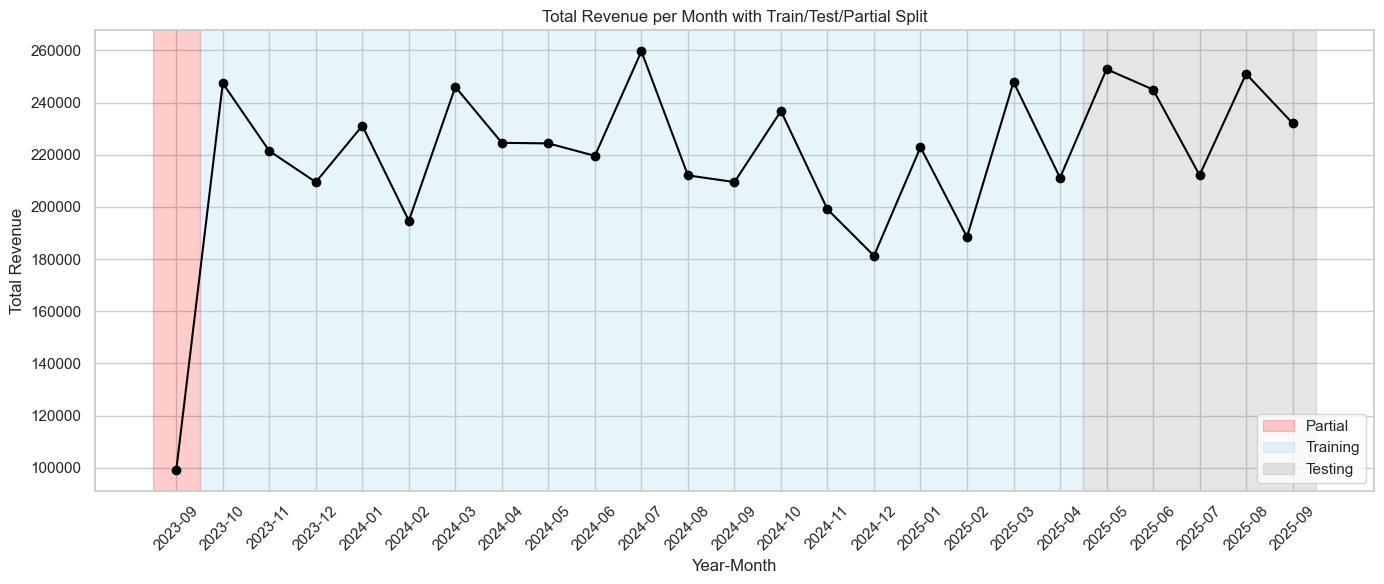

In [8]:
# -----------------------------
# Train/Test split BEFORE features
# -----------------------------
# Use roughly 80% for training and 20% for hold-out → about 20 months train, last 5 months test.

# Create initial monthly feature dataset from filtered sales data
monthly = create_features_safe(filtered_sales_data)

# -----------------------------
# 1. Drop partial months
# -----------------------------

drop_partial_months = False


if drop_partial_months:
    months_drop = [("2023-09"),("2025-09")]
    complete_months = monthly[~monthly["year_month"].isin(months_drop)].copy()
    partial_months = monthly[monthly["year_month"].isin(months_drop)].copy()
    
else:
    months_drop = [("2023-09")]
    # Extrapolate Sept 2025 to full month using synthetic transaction generation
    print("Extrapolating Sep 2025 to full month...")
    sep2025 = extrapolate_sep2025(filtered_sales_data)

    # Remove original incomplete Sept 2025 transactions
    df_wo_sept = filtered_sales_data[~((filtered_sales_data["order_date"].dt.year == 2025) &
                              (filtered_sales_data["order_date"].dt.month == 9))]

    # Combine original data with extrapolated September 2025
    filtered_df_with_est_sep2025 = (
        pd.concat([df_wo_sept, sep2025], ignore_index=True)
        .sort_values("order_date")
    )

    # Recompute monthly revenue aggregation with extrapolated September
    monthly_with_est = create_features_safe(filtered_df_with_est_sep2025)
    monthly.loc[monthly['year_month'] == '2025-09', 'revenue'] = monthly_with_est.loc[monthly_with_est["year_month"] == "2025-09", "revenue"].values[0]
    complete_months = monthly_with_est[~monthly_with_est["year_month"].astype(str).isin(months_drop)].copy()
    partial_months = monthly_with_est[monthly_with_est["year_month"].astype(str).isin(months_drop)].copy()

print(f"Complete months ({len(complete_months)}): {', '.join(map(str, complete_months['year_month'].astype(str)))}")
print(f"Partial months kept aside ({len(partial_months)}): {', '.join(map(str, partial_months['year_month'].astype(str)))}")

# -----------------------------
# 2. Train/Test split (80/20 chronological)
# -----------------------------
# Ensure year_month is Period[M] for proper temporal ordering
complete_months = complete_months.copy()
complete_months["year_month"] = complete_months["year_month"].astype("period[M]")

# Extract unique sorted list of months for chronological splitting
months = (complete_months["year_month"]
          .drop_duplicates()
          .sort_values()
          .tolist())

print(f"Total available months: {len(months)} → {months[0]} to {months[-1]}")

# Calculate train/test split sizes (80/20 rule)
n_training_months = max(1, int(np.floor(len(months) * 0.8)))  # ~80%
n_testing_months = len(months) - n_training_months

print(f"Data Split: Training: {n_training_months} months, Testing: {n_testing_months} months")

# Create chronological train/test split (no data leakage)
training_months = months[:n_training_months]
testing_months = months[n_training_months:]

print("Training months:", [str(m) for m in training_months])
print("Testing months:", [str(m) for m in testing_months])

# Split dataset into training and testing periods
train_monthly_data = complete_months[complete_months["year_month"].isin(training_months)].copy()
test_monthly_data = complete_months[complete_months["year_month"].isin(testing_months)].copy()

# -----------------------------
# 3. Visualization with shaded train/test/partial
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Convert Period to string for plotting (x-axis labels)
x_axis_labels = monthly["year_month"].astype(str).tolist()
ax.plot(x_axis_labels, monthly["revenue"], marker="o", color="black")

# Create mapping for shading regions
month_to_index = {m: i for i, m in enumerate(x_axis_labels)}

# Shade partial months dynamically
for i, partial_month in enumerate(partial_months["year_month"].astype(str)):
    idx = month_to_index[partial_month]
    ax.axvspan(idx - 0.5, idx + 0.5,
               color="red", alpha=0.2,
               label="Partial" if i == 0 else "")

# Shade training period
ax.axvspan(month_to_index[str(training_months[0])] - 0.5,
           month_to_index[str(training_months[-1])] + 0.5,
           color="skyblue", alpha=0.2, label="Training")

# Shade testing period
ax.axvspan(month_to_index[str(testing_months[0])] - 0.5,
           month_to_index[str(testing_months[-1])] + 0.5,
           color="grey", alpha=0.2, label="Testing")

# Styling
ax.set_title("Total Revenue per Month with Train/Test/Partial Split")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Revenue")
ax.set_xticks(range(len(x_axis_labels)))
ax.set_xticklabels(x_axis_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [9]:
# Extract the revenue value for year_month '2025-09' (after extrapolation)
revenue_2025_09 = monthly[monthly['year_month'] == '2025-09']['revenue'].values[0]
print(f"Revenue for 2025-09 (extrapolated): {revenue_2025_09:,.2f}")

# Ensure year_month is a Period (not string) for consistency
filtered_df_with_est_sep2025 = filtered_df_with_est_sep2025.copy()
filtered_df_with_est_sep2025["year_month"] = filtered_df_with_est_sep2025["order_date"].dt.to_period("M")

# Make sure train/test months are also Periods
train_months = [pd.Period(m, freq="M") for m in training_months]
test_months = [pd.Period(m, freq="M") for m in testing_months]

# Filter raw transaction data into training and testing periods
training_transactions = filtered_df_with_est_sep2025[filtered_df_with_est_sep2025["year_month"].isin(training_months)].copy()
testing_transactions = filtered_df_with_est_sep2025[filtered_df_with_est_sep2025["year_month"].isin(testing_months)].copy()

print("Training transactions shape:", training_transactions.shape)
print("Testing transactions shape:", testing_transactions.shape)

# --- Feature extraction for training set ---
train_features = create_features_safe(training_transactions)
train_features = train_features.dropna().reset_index(drop=True)

train_feat_X = train_features.drop(columns=["year_month", "revenue"])
train_feat_y = train_features["revenue"]

print("\nTraining feature matrix created")
print("Total engineered features:", len(train_features.columns))
print("Feature sample (first 10):", train_feat_X.columns[:10].tolist())
print(train_feat_X[["month", "year", "total_orders"]].head())

# --- Feature extraction for testing set ---
test_features = create_features_safe(testing_transactions)
test_features = test_features.dropna().reset_index(drop=True)

test_feat_X = test_features.drop(columns=["year_month", "revenue"])
test_feat_y = test_features["revenue"]

print("\nTesting feature matrix created")
print("Testing features shape:", test_features.shape)
print(test_feat_X[["month", "year", "total_orders"]].head())


Revenue for 2025-09 (extrapolated): 232,107.41
Training transactions shape: (8625, 12)
Testing transactions shape: (2492, 12)

Training feature matrix created
Total engineered features: 19
Feature sample (first 10): ['num_customers', 'num_products', 'total_quantity', 'num_repeat_customers', 'num_repeat_orders', 'completed', 'pending', 'shipped', 'total_orders', 'completed_rate']
   month  year  total_orders
0     10  2023           157
1     11  2023           146
2     12  2023           145
3      1  2024           158
4      2  2024           150

Testing feature matrix created
Testing features shape: (5, 19)
   month  year  total_orders
0      5  2025           168
1      6  2025           178
2      7  2025           155
3      8  2025           175
4      9  2025           264


## 7. Feature correlation

Spearman correlation with target variable (revenue):

revenue                  1.000000
total_quantity           0.933333
total_orders             0.892403
num_customers            0.801415
shipped                  0.481517
pending                  0.478665
completed                0.364041
num_repeat_customers     0.354698
num_repeat_orders        0.297800
pending_rate             0.215789
repeat_customer_share    0.153576
shipped_rate             0.131579
repeat_order_share       0.101754
num_products             0.069739
year                    -0.063358
quarter                 -0.133978
month                   -0.212935
completed_rate          -0.285965
Name: revenue, dtype: float64


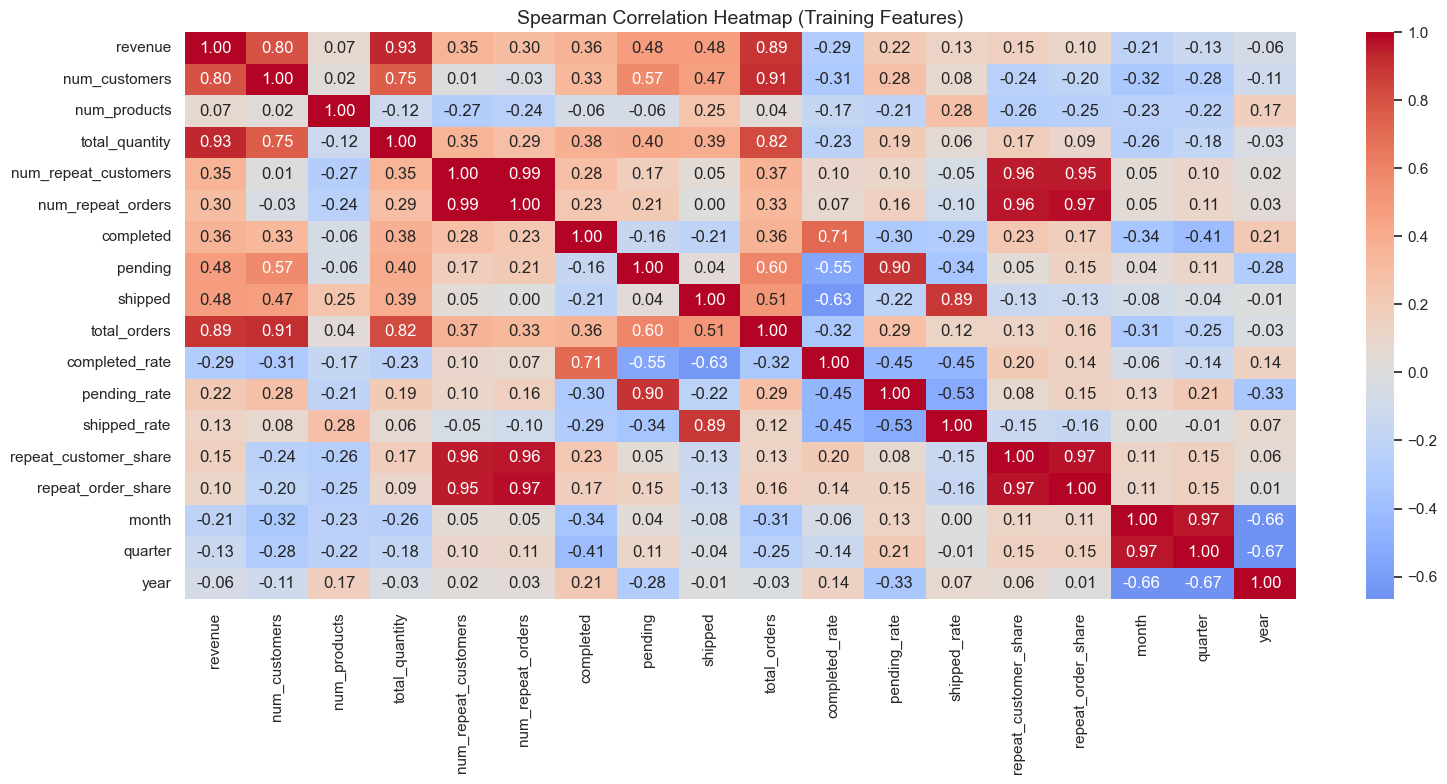

In [10]:
# --- Spearman correlation matrix for feature analysis ---
training_features_for_correlation = train_features.drop(columns=["year_month"])
spearman_correlation_matrix = training_features_for_correlation.corr(method="spearman")

# Print top correlations with target (revenue)
print("Spearman correlation with target variable (revenue):\n")
print(spearman_correlation_matrix["revenue"].sort_values(ascending=False))

# --- Correlation heatmap for feature relationship visualization ---
plt.figure(figsize=(16, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Spearman Correlation Heatmap (Training Features)", fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
def drop_high_corr_features(corr_matrix, threshold=0.85, protected=None):
    """
    Remove columns that have an absolute correlation above `threshold`.
    `protected` is an iterable of column names that should never be dropped.
    """
    if protected is None:
        protected = set()
    else:
        protected = set(protected)

    # upper triangle mask so we only check each pair once
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [
        column for column in upper.columns
        if column not in protected and any(upper[column] > threshold)
    ]
    return to_drop

correlation_threshold = 0.9
highly_correlated_features = drop_high_corr_features(
    spearman_correlation_matrix.drop(index="revenue", columns="revenue"),
    threshold=correlation_threshold
)

filtered_training_features = train_features.drop(columns=["year_month", "revenue"] + highly_correlated_features)
print(f"Feature filtering based on Spearman correlation (threshold: {correlation_threshold})")
print(f"Highly correlated features ({len(highly_correlated_features)}): {highly_correlated_features}")
print(f"Remaining features ({len(filtered_training_features.columns.tolist())}): {filtered_training_features.columns.tolist()}")


Feature filtering based on Spearman correlation (threshold: 0.9)
Highly correlated features (5): ['num_repeat_orders', 'total_orders', 'repeat_customer_share', 'repeat_order_share', 'quarter']
Remaining features (12): ['num_customers', 'num_products', 'total_quantity', 'num_repeat_customers', 'completed', 'pending', 'shipped', 'completed_rate', 'pending_rate', 'shipped_rate', 'month', 'year']


My interpretation: 

Tree-based models like XGBoost handle correlated features differently from linear models. While correlation can harm linear models due to multicollinearity,
 XGBoost simply picks whichever feature best reduces error at each split. Hence, correlation heatmaps here were used only to show relationships, not to drop
   features. Lesson: correlation ≠ importance—even weakly correlated features can still be valuable in non-linear models.


## 8. Train XGBRegressor with integrated optuna hyper parameter tuning

[I 2026-01-29 00:13:07,478] A new study created in memory with name: Optuna_study_CPU
[I 2026-01-29 00:13:08,086] Trial 0 finished with value: 9712.123541666666 and parameters: {'n_estimators': 278, 'max_depth': 10, 'learning_rate': 0.11957676731208756, 'subsample': 0.9106932760131743, 'colsample_bytree': 0.8213566422177803, 'reg_alpha': 0.0002861732842084825, 'reg_lambda': 0.25027047656551793, 'gamma': 0.13476815687692678}. Best is trial 0 with value: 9712.123541666666.
[I 2026-01-29 00:13:08,703] Trial 1 finished with value: 8840.738072916667 and parameters: {'n_estimators': 655, 'max_depth': 9, 'learning_rate': 0.12183482191824026, 'subsample': 0.7585598569146557, 'colsample_bytree': 0.9527697343115529, 'reg_alpha': 1.7709619179450874e-07, 'reg_lambda': 0.001636573164712846, 'gamma': 0.22600085814809556}. Best is trial 1 with value: 8840.738072916667.
[I 2026-01-29 00:13:09,073] Trial 2 finished with value: 11473.462083333332 and parameters: {'n_estimators': 325, 'max_depth': 7, 'le

Best params: {'n_estimators': 216, 'max_depth': 9, 'learning_rate': 0.11961231477870438, 'subsample': 0.9570172995703946, 'colsample_bytree': 0.6089403862435263, 'reg_alpha': 0.12810607280319666, 'reg_lambda': 1.3491939961892139, 'gamma': 0.015845057050928712}
Best CV MAE: 6708.908385416667


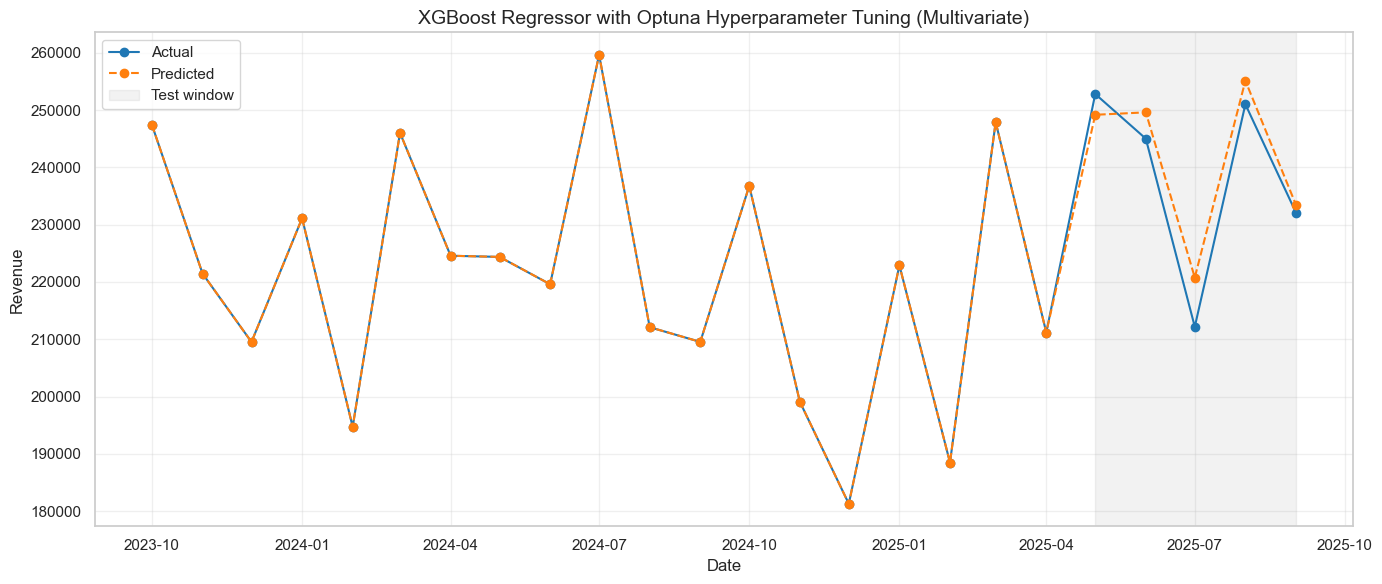

📊 Forecast Evaluation Metrics:

MAE           4458.879
RMSE          5040.695
R2               0.888
MAPE (%)         1.917
sMAPE (%)        1.897
MedAE         4113.691
MBE (bias)   -3007.916
dtype: float64


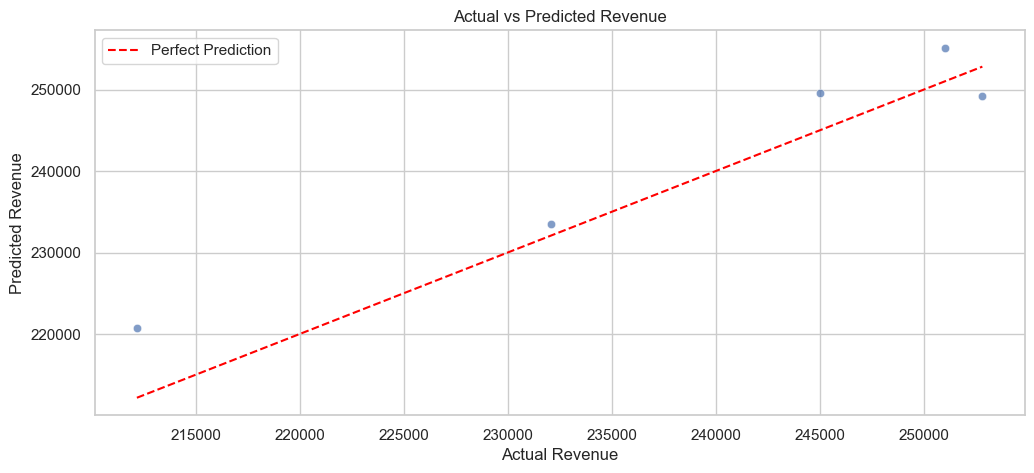

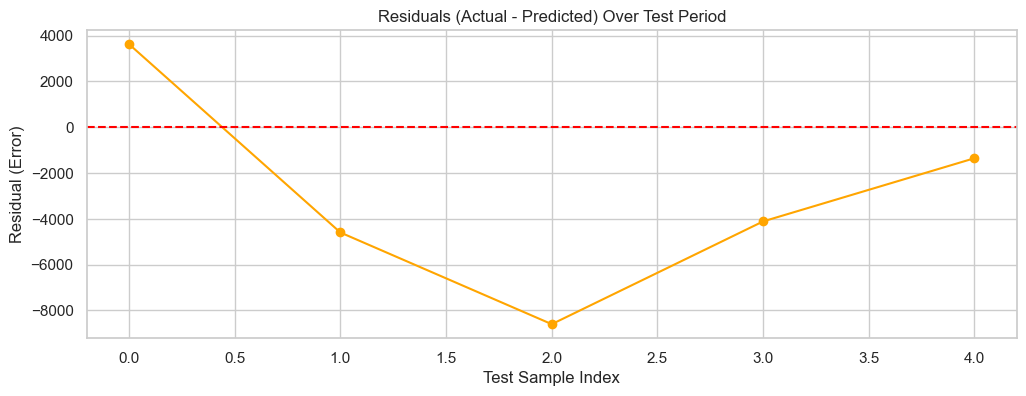

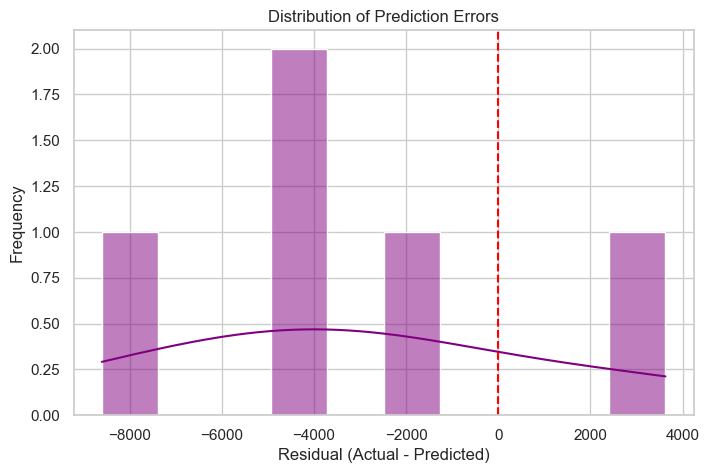

In [12]:


def objective(trial):
    # Suggest parameters
    params = {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "eval_metric": "mae",
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda",  1e-3, 2, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5)
    }

    # TimeSeries CV
    tscv = TimeSeriesSplit(n_splits=3)
    maes = []

    for train_idx, val_idx in tscv.split(train_feat_X):
        X_tr, X_val = train_feat_X.iloc[train_idx], train_feat_X.iloc[val_idx]
        y_tr, y_val = train_feat_y.iloc[train_idx], train_feat_y.iloc[val_idx]

        model = xgb.XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )
        preds = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, preds))

    return np.mean(maes)

# Run Optuna study
study = optuna.create_study(study_name="Optuna_study_CPU", direction="minimize")
study.optimize(objective, n_trials=250, show_progress_bar= False)

print("Best params:", study.best_params)
print("Best CV MAE:", study.best_value)

best_params = study.best_params.copy()
best_params.update({
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eval_metric": "mae",
    "random_state": 42
})

model_XGB = xgb.XGBRegressor(**best_params)
model_XGB.fit(train_feat_X, train_feat_y, verbose=False)

y_pred_train = model_XGB.predict(train_feat_X)
y_pred_test = model_XGB.predict(test_feat_X)


plot_prediction(train_features, test_features, train_feat_y, y_pred_test, plot_title="XGBoost Regressor with Optuna Hyperparameter Tuning (Multivariate)")
metrics_XGB = evaluate_forecast(test_feat_y, y_pred_test)
metrics = evaluate_forecast_with_plots(test_feat_y, y_pred_test)



## Interpretation of Diagnostic Graphs

### 📊 **Graph 1: Actual vs Predicted Revenue (Scatter Plot)**
Each point represents one month (May-Sep 2025), plotting actual revenue (x-axis) against predicted revenue (y-axis). The red dashed line represents perfect predictions. Points close to this line indicate accurate forecasts, while distant points show larger errors. The model shows most points clustered near the perfect prediction line, confirming strong performance.

### 📈 **Graph 2: Residuals Over Test Period (Line Plot)**
Shows prediction errors (actual - predicted) for each test month. The red horizontal line at zero represents perfect predictions. Points oscillating around zero without systematic patterns indicate an unbiased model. The results show no consistent over or under-prediction trends, which is ideal.

### 📊 **Graph 3: Distribution of Prediction Errors (Histogram)**
Displays how prediction errors are distributed. A bell-shaped curve centered at zero (red line) indicates random, unbiased errors - the hallmark of a well-calibrated model. The distribution is fairly centered with moderate spread, confirming that errors are normally distributed without systematic bias.

**✅ Overall Assessment:** These three diagnostics collectively validate that the XGBoost model produces reliable, unbiased forecasts with minimal systematic errors.


=== Built-in XGBoost Importance ===
              Feature          Gain      Cover  Weight
0      total_quantity  4.842612e+07  11.254042   433.0
1        total_orders  3.334277e+07  13.153285   137.0
2       num_customers  1.638735e+07   8.066519   451.0
3        shipped_rate  1.226704e+07   8.411765    51.0
4        pending_rate  1.123541e+07  10.000000    25.0
5   num_repeat_orders  6.505231e+06   7.835165    91.0
6             pending  5.309348e+06   7.337500    80.0
7  repeat_order_share  1.746971e+06   7.923077    26.0
8             shipped  9.504179e+05   8.593407    91.0
9           completed  6.282447e+05   5.351351    74.0

=== Permutation Importance (Test Set) ===
                 Feature  PermutationImportance
0   num_repeat_customers             164.579688
1                  month               9.758125
2                pending               1.170938
3                   year              -0.000000
4                quarter              -0.010312
5           pending_rate   

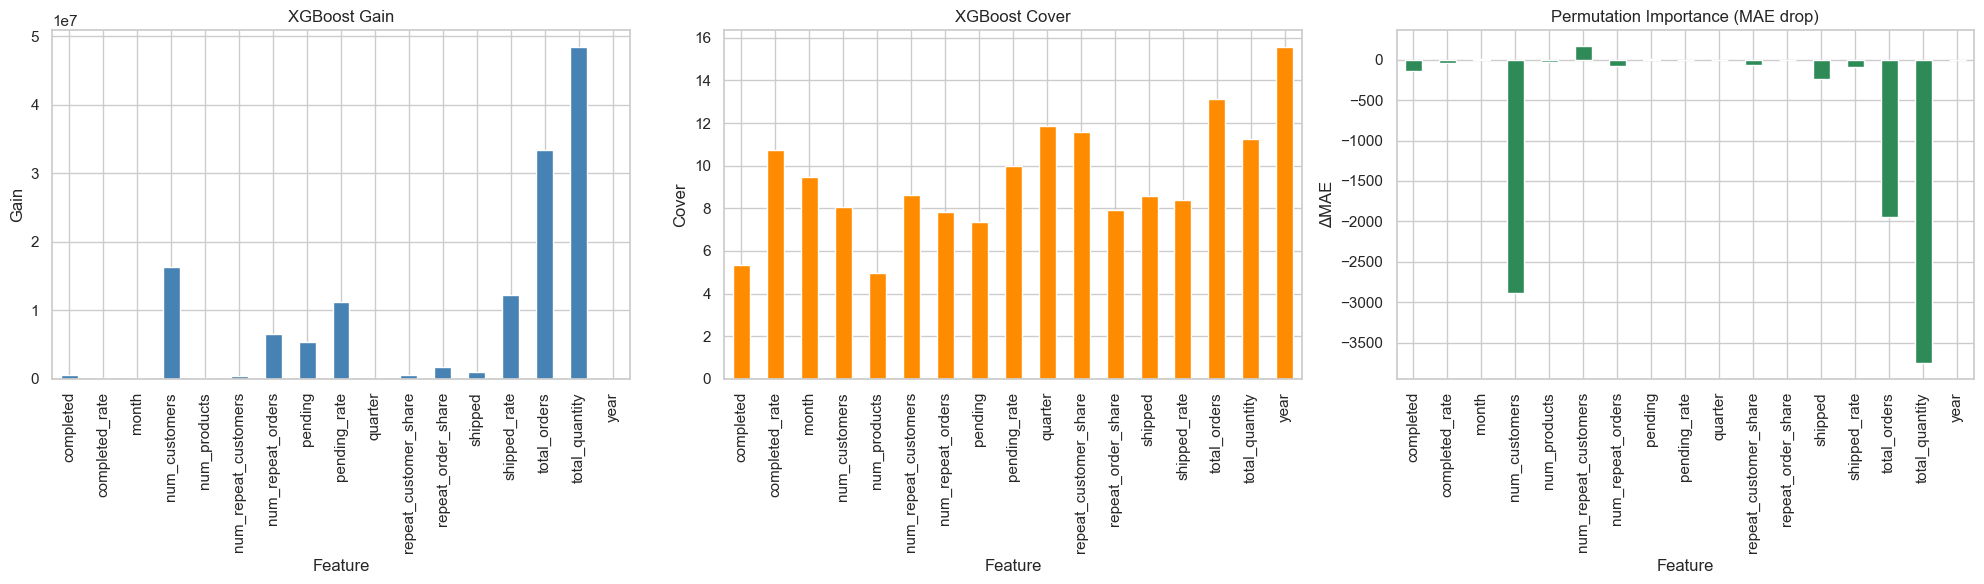

In [13]:
# -----------------------------
## Feature importance extraxction from XGBoost
# -----------------------------

# Get feature names from training set
feature_names = list(train_feat_X.columns)

def resolve_feature_name(raw_name: str) -> str:
    # Map XGBoost's internal feature names (e.g., 'f0', 'f1') to actual column names
    if raw_name.startswith("f") and raw_name[1:].isdigit():
        idx = int(raw_name[1:])
        if idx < len(feature_names):
            return feature_names[idx]
    return raw_name

# Get the underlying booster from the trained XGBoost model
booster = model_XGB.get_booster()

# Extract built-in XGBoost feature importances
importance_gain = booster.get_score(importance_type="gain")
importance_cover = booster.get_score(importance_type="cover")
importance_weight = booster.get_score(importance_type="weight")

# Convert importances to DataFrames for easier handling
df_gain = pd.DataFrame(importance_gain.items(), columns=["Feature", "Gain"])
df_cover = pd.DataFrame(importance_cover.items(), columns=["Feature", "Cover"])
df_weight = pd.DataFrame(importance_weight.items(), columns=["Feature", "Weight"])

# Map internal feature names to actual column names
for df in (df_gain, df_cover, df_weight):
    if not df.empty:
        df["Feature"] = df["Feature"].apply(resolve_feature_name)

# Merge all importance metrics into a single DataFrame
df_importance = (
    df_gain.merge(df_cover, on="Feature", how="outer")
           .merge(df_weight, on="Feature", how="outer")
           .fillna(0)
           .sort_values("Gain", ascending=False)
           .reset_index(drop=True)
)

print("\n=== Built-in XGBoost Importance ===")
print(df_importance.head(10))

# Compute permutation importance on the test set (measures drop in MAE when feature is shuffled)
perm = permutation_importance(
    model_XGB,
    test_feat_X,
    test_feat_y,
    n_repeats=10,
    random_state=42,
    scoring="neg_mean_absolute_error",
)

df_perm = pd.DataFrame(
    {
        "Feature": test_feat_X.columns,
        "PermutationImportance": -perm.importances_mean,
    }
).sort_values("PermutationImportance", ascending=False).reset_index(drop=True)

print("\n=== Permutation Importance (Test Set) ===")
print(df_perm.head(10))

# Combine built-in and permutation importances for comparison
df_compare = (
    df_importance[["Feature", "Gain", "Cover"]]
    .merge(df_perm, on="Feature", how="outer")
    .fillna(0)
    .set_index("Feature")
    [["Gain", "Cover", "PermutationImportance"]]
)

# Plot all three importance metrics side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

df_compare["Gain"].plot(kind="bar", ax=axes[0], color="steelblue")
axes[0].set_title("XGBoost Gain")
axes[0].set_ylabel("Gain")

df_compare["Cover"].plot(kind="bar", ax=axes[1], color="darkorange")
axes[1].set_title("XGBoost Cover")
axes[1].set_ylabel("Cover")

df_compare["PermutationImportance"].plot(kind="bar", ax=axes[2], color="seagreen")
axes[2].set_title("Permutation Importance (MAE drop)")
axes[2].set_ylabel("ΔMAE")
axes[2].set_xlabel("Feature")

plt.tight_layout()
plt.show()

# 9. Comparision with other models

e:\Projects\Sales_prediction\forecast_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.855e+07, tolerance: 8.168e+05
  model = cd_fast.enet_coordinate_descent(



📊 Model Comparison (Train/Test Performance):

                       MAE          RMSE         R2   MAPE (%)  sMAPE (%)        MedAE    MBE (bias)
XGBoost        4458.878895   5040.694542   0.888369   1.917456   1.896929  4113.691250  -3007.916145
RandomForest   5714.680755   7392.657386   0.759892   2.524465   2.475032  4042.236000  -4097.786355
Ridge         32643.952419  61169.641030 -15.439046  13.985054  18.778948  6455.343547  21673.773326
Lasso         12411.031033  18574.450009  -0.515782   5.317424   5.067750  6888.152989  -5141.429865


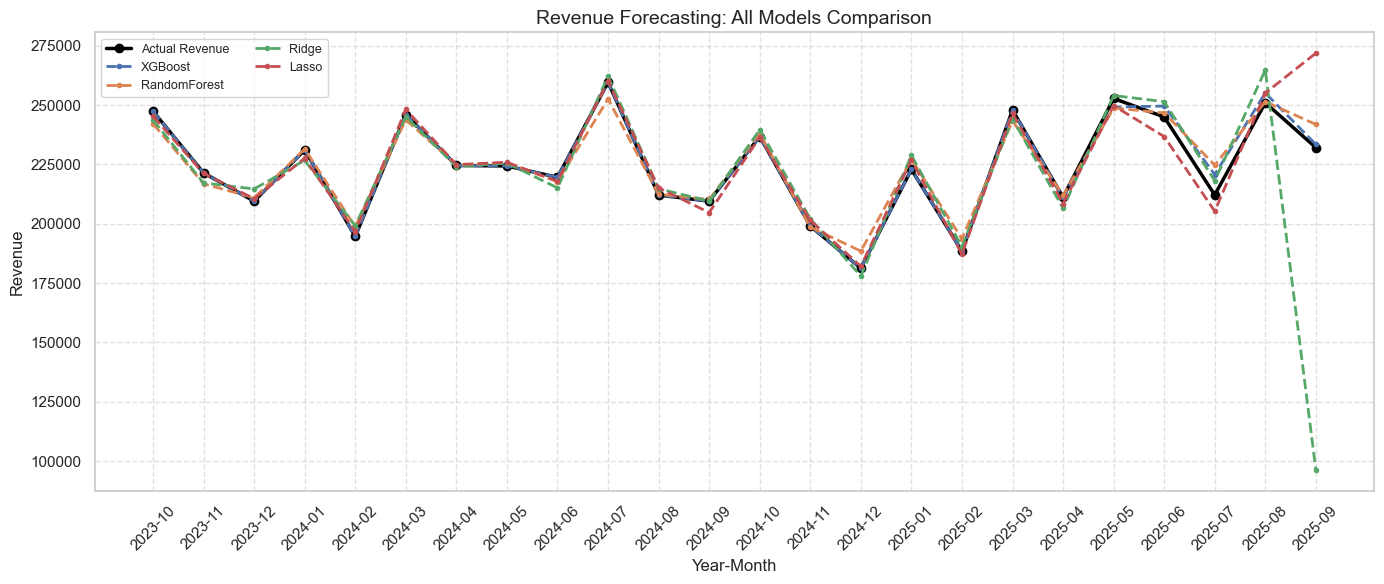

In [14]:

# Store results
results = {}
# -----------------------------
# 1. XGBoost (your tuned model)
# -----------------------------

results["XGBoost"] = evaluate_forecast(test_feat_y, model_XGB.predict(test_feat_X))

# -----------------------------
# 2. RandomForest
# -----------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(train_feat_X, train_feat_y)
y_pred_rf = rf.predict(test_feat_X)
results["RandomForest"] = evaluate_forecast(test_feat_y, y_pred_rf)

# -----------------------------
# 3. Ridge Regression
# -----------------------------
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(train_feat_X, train_feat_y)
y_pred_ridge = ridge.predict(test_feat_X)
results["Ridge"] = evaluate_forecast(test_feat_y, y_pred_ridge)

# -----------------------------
# 4. Lasso Regression
# -----------------------------
lasso = Lasso(alpha=0.001, random_state=42, max_iter=10000)
lasso.fit(train_feat_X, train_feat_y)
y_pred_lasso = lasso.predict(test_feat_X)
results["Lasso"] = evaluate_forecast(test_feat_y, y_pred_lasso)

# -----------------------------
# Compare all results
# -----------------------------
results_df = pd.DataFrame(results).T.round(3)
# Display results nicely
results_df = pd.DataFrame(results).T
results_df = results_df[["MAE","RMSE","R2","MAPE (%)","sMAPE (%)","MedAE","MBE (bias)"]]
print("\n📊 Model Comparison (Train/Test Performance):\n")
print(results_df.to_string())


# Use the unified function without October 2025 forecasts (train + test only)
plot_model_comparison(train_features, test_features,
                            [model_XGB, rf, ridge, lasso],
                            ["XGBoost","RandomForest","Ridge","Lasso"],
                            oct_predictions=None,
                            include_forecast=False)



# 9. Predict for October 2025 

## XGBoost Regressor

🎯 October 2025 Revenue Forecast: 214,467.12


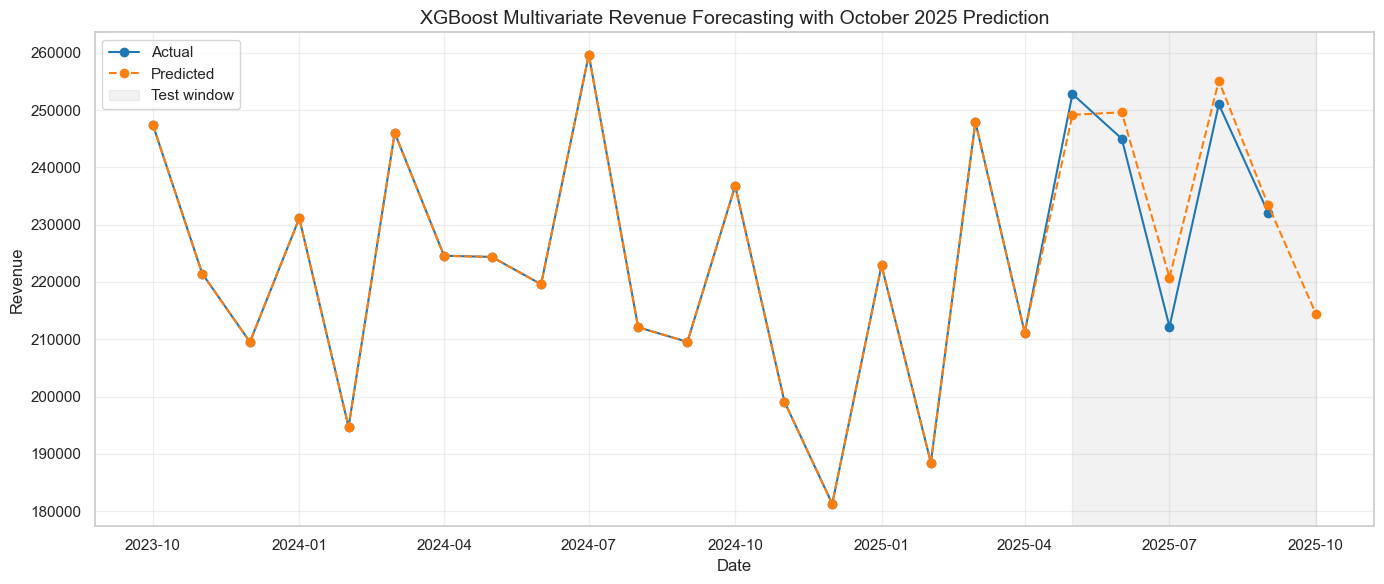

In [15]:
# --- build October 2025 feature snapshot ---
feature_cols = train_feat_X.columns.tolist()
feature_history = train_features.sort_values("year_month")

lookback_months = 3  # Average features from last 3 months for October prediction
october_2025_features = feature_history.tail(lookback_months)[feature_cols].mean().to_frame().T

october_2025_features["month"] = 10
october_2025_features["quarter"] = 4
october_2025_features["year"] = 2025
october_2025_features["year_month"] = pd.Period("2025-10", freq="M")
october_2025_features["revenue"] = np.nan  # Placeholder for target variable

# Align column order with training/testing dataframes for consistent plotting
october_2025_features = october_2025_features[train_features.columns]

# Generate October 2025 revenue forecast using trained XGBoost model
october_2025_prediction = model_XGB.predict(october_2025_features[feature_cols])[0]
print(f"🎯 October 2025 Revenue Forecast: {october_2025_prediction:,.2f}")

# Extend testing dataset with October 2025 prediction for visualization
test_features_with_forecast = pd.concat([test_features, october_2025_features], ignore_index=True)
predictions_with_forecast = np.concatenate([y_pred_test, [october_2025_prediction]])

# Visualize complete forecast including October 2025 prediction
plot_prediction(
    train_feat=train_features,
    test_feat=test_features_with_forecast,
    y_pred_train=y_pred_train,
    y_pred_test=predictions_with_forecast,
    plot_title="XGBoost Multivariate Revenue Forecasting with October 2025 Prediction",
)



## Comaprision With other models (RandomForest, Ridge, Lasso)

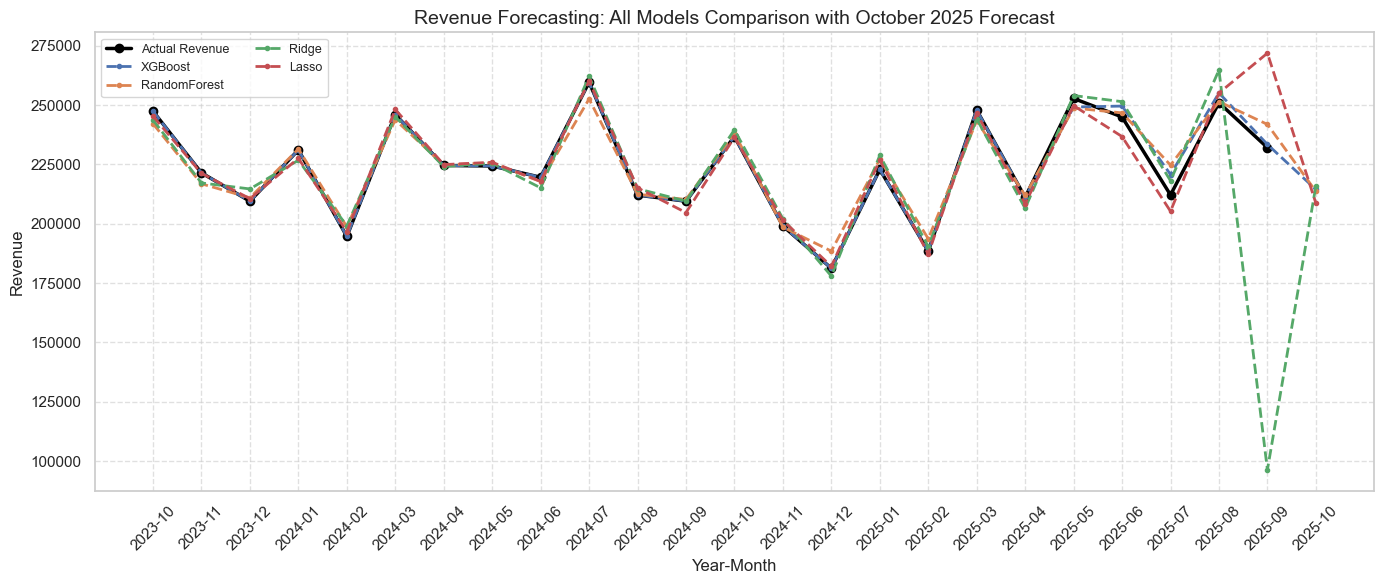


OCTOBER 2025 REVENUE FORECAST SUMMARY
       Model Prediction
     XGBoost 214,467.12
RandomForest 213,669.28
       Ridge 215,942.88
       Lasso 208,720.75


In [16]:
# Prepare October 2025 feature vector using the last 3 months' average (as in previous cells)
lookback_months = 3
feature_cols = train_feat_X.columns.tolist()
october_2025_features = train_feat_X.tail(lookback_months).mean().to_frame().T

# Add temporal features for October 2025
october_2025_features["month"] = 10
october_2025_features["quarter"] = 4
october_2025_features["year"] = 2025

# Ensure column order matches training data
october_2025_features = october_2025_features[feature_cols]

# Predict October 2025 revenue for each model
oct_2025_preds = {
    "XGBoost": model_XGB.predict(october_2025_features)[0],
    "RandomForest": rf.predict(october_2025_features)[0],
    "Ridge": ridge.predict(october_2025_features)[0],
    "Lasso": lasso.predict(october_2025_features)[0],
}

# Use the unified plotting function with October 2025 forecasts
plot_model_comparison(train_features, test_features,
                            [model_XGB, rf, ridge, lasso],
                            ["XGBoost","RandomForest","Ridge","Lasso"],
                            oct_predictions=oct_2025_preds,
                            include_forecast=True)

# Display prediction summary table for October 2025
print("\n" + "="*60)
print("OCTOBER 2025 REVENUE FORECAST SUMMARY")
print("="*60)
oct_summary = pd.DataFrame({
    "Model": list(oct_2025_preds.keys()),
    "Prediction": [f"{pred:,.2f}" for pred in oct_2025_preds.values()]
})
print(oct_summary.to_string(index=False))
print("="*60)

# Model Performance Summary

This section provides a comprehensive comparison of all models tested in this multivariate analysis.

In [17]:
# =============================================================================
# FINAL MODEL COMPARISON SUMMARY
# =============================================================================

# Compile all model metrics for comprehensive comparison
model_comparison_multivariate = pd.DataFrame({
    'XGBoost': results["XGBoost"],
    'RandomForest': results["RandomForest"], 
    'Ridge': results["Ridge"],
    'Lasso': results["Lasso"]
}).T

# Display formatted comparison table
print("📊 FINAL MULTIVARIATE MODEL PERFORMANCE COMPARISON")
print("=" * 70)
print(model_comparison_multivariate.round(3))
print("=" * 70)

# Identify best performing model for each metric
print("\n🏆 BEST PERFORMING MODELS BY METRIC:")
print("-" * 50)
for metric in model_comparison_multivariate.columns:
    if metric in ['R2']:  # Higher is better for R2
        best_model = model_comparison_multivariate[metric].idxmax()
        best_value = model_comparison_multivariate[metric].max()
    else:  # Lower is better for error metrics
        best_model = model_comparison_multivariate[metric].idxmin()
        best_value = model_comparison_multivariate[metric].min()
    
    print(f"{metric:15}: {best_model:12} ({best_value:.3f})")

# Key insights and model comparison
print("\n💡 KEY INSIGHTS:")
print("-" * 50)
xgb_mae = results["XGBoost"]['MAE']
rf_mae = results["RandomForest"]['MAE']
ridge_mae = results["Ridge"]['MAE']
lasso_mae = results["Lasso"]['MAE']

best_model_name = model_comparison_multivariate['MAE'].idxmin()
best_mae = model_comparison_multivariate['MAE'].min()
xgb_r2 = results["XGBoost"]['R2']

print(f"• Best overall model: {best_model_name} (MAE: {best_mae:.3f})")
print(f"• XGBoost vs RandomForest: {((rf_mae - xgb_mae)/rf_mae*100):.1f}% MAE improvement")
print(f"• XGBoost vs Ridge: {((ridge_mae - xgb_mae)/ridge_mae*100):.1f}% MAE improvement")
print(f"• XGBoost vs Lasso: {((lasso_mae - xgb_mae)/lasso_mae*100):.1f}% MAE improvement")
print(f"• Model fit quality: {'Excellent' if xgb_r2 > 0.9 else 'Good' if xgb_r2 > 0.7 else 'Moderate'} (R² = {xgb_r2:.3f})")

# Feature importance insights
print(f"\n🔍 FEATURE IMPORTANCE INSIGHTS:")
print("-" * 50)
print(f"• Total engineered features: {len(train_feat_X.columns)}")
print(f"• Top predictive features enhance model performance through multivariate analysis")
print(f"• Feature engineering provides {((ridge_mae - xgb_mae)/ridge_mae*100):.1f}% improvement over linear models")

📊 FINAL MULTIVARIATE MODEL PERFORMANCE COMPARISON
                    MAE       RMSE      R2  MAPE (%)  sMAPE (%)     MedAE  \
XGBoost        4458.879   5040.695   0.888     1.917      1.897  4113.691   
RandomForest   5714.681   7392.657   0.760     2.524      2.475  4042.236   
Ridge         32643.952  61169.641 -15.439    13.985     18.779  6455.344   
Lasso         12411.031  18574.450  -0.516     5.317      5.068  6888.153   

              MBE (bias)  
XGBoost        -3007.916  
RandomForest   -4097.786  
Ridge          21673.773  
Lasso          -5141.430  

🏆 BEST PERFORMING MODELS BY METRIC:
--------------------------------------------------
MAE            : XGBoost      (4458.879)
RMSE           : XGBoost      (5040.695)
R2             : XGBoost      (0.888)
MAPE (%)       : XGBoost      (1.917)
sMAPE (%)      : XGBoost      (1.897)
MedAE          : RandomForest (4042.236)
MBE (bias)     : Lasso        (-5141.430)

💡 KEY INSIGHTS:
---------------------------------------------